# Lightweight image generation with aMUSEd and OpenVINO

[Amused](https://huggingface.co/docs/diffusers/api/pipelines/amused) is a lightweight text to image model based off of the [muse](https://arxiv.org/pdf/2301.00704.pdf) architecture. Amused is particularly useful in applications that require a lightweight and fast model such as generating many images quickly at once.

Amused is a VQVAE token based transformer that can generate an image in fewer forward passes than many diffusion models. In contrast with muse, it uses the smaller text encoder CLIP-L/14 instead of t5-xxl. Due to its small parameter count and few forward pass generation process, amused can generate many images quickly. This benefit is seen particularly at larger batch sizes.

<img src="https://huggingface.co/amused/amused-256/resolve/main/assets/collage_small.png" width="800" height="800"> 


<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/amused-lightweight-text-to-image/amused-lightweight-text-to-image.ipynb" />








#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load and run the original pipeline](#Load-and-run-the-original-pipeline)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
    - [Convert the Text Encoder](#Convert-the-Text-Encoder)
    - [Convert the U-ViT transformer](#Convert-the-U-ViT-transformer)
    - [Convert VQ-GAN decoder (VQVAE)](#Convert-VQ-GAN-decoder-(VQVAE))
- [Compiling models and prepare pipeline](#Compiling-models-and-prepare-pipeline)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run model quantization](#Run-model-quantization)
    - [Compute Inception Scores and inference time](#Compute-Inception-Scores-and-inference-time)
- [Interactive inference](#Interactive-inference)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q transformers "diffusers>=0.25.0" "openvino>=2023.2.0" "accelerate>=0.20.3" "gradio>=4.19" "torch>=2.1" "pillow" "torchmetrics" "torch-fidelity" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "nncf>=2.9.0" datasets

In [ ]:
# Fetch the notebook utils script from the openvino_notebooks repo
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

## Load and run the original pipeline
[back to top ⬆️](#Table-of-contents:)

In [2]:
import torch
from diffusers import AmusedPipeline


pipe = AmusedPipeline.from_pretrained(
    "amused/amused-256",
)

prompt = "kind smiling ghost"
image = pipe(prompt, generator=torch.Generator("cpu").manual_seed(8)).images[0]
image.save("text2image_256.png")

/home/nsavel/venvs/ov_notebooks/lib/python3.8/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

2024-04-11 16:00:38.860389: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 16:00:38.912601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 16:00:39.568772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.97it/s]


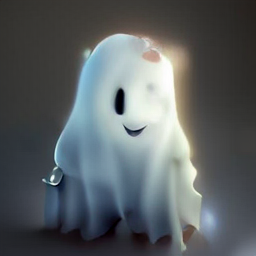

In [3]:
image

## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

aMUSEd consists of three separately trained components: a pre-trained CLIP-L/14 text encoder, a VQ-GAN, and a U-ViT.

![image_png](https://cdn-uploads.huggingface.co/production/uploads/5dfcb1aada6d0311fd3d5448/97ca2Vqm7jBfCAzq20TtF.png)

During inference, the U-ViT is conditioned on the text encoder’s hidden states and iteratively predicts values for all masked tokens. The cosine masking schedule determines a percentage of the most confident token predictions to be fixed after every iteration. After 12 iterations, all tokens have been predicted and are decoded by the VQ-GAN into image pixels.

Define paths for converted models:

In [4]:
from pathlib import Path


TRANSFORMER_OV_PATH = Path("models/transformer_ir.xml")
TEXT_ENCODER_OV_PATH = Path("models/text_encoder_ir.xml")
VQVAE_OV_PATH = Path("models/vqvae_ir.xml")

Define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file.

In [5]:
import torch

import openvino as ov


def convert(model: torch.nn.Module, xml_path: str, example_input):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        with torch.no_grad():
            converted_model = ov.convert_model(model, example_input=example_input)
        ov.save_model(converted_model, xml_path, compress_to_fp16=False)

        # cleanup memory
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

### Convert the Text Encoder
[back to top ⬆️](#Table-of-contents:)

In [6]:
class TextEncoderWrapper(torch.nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.text_encoder = text_encoder

    def forward(self, input_ids=None, return_dict=None, output_hidden_states=None):
        outputs = self.text_encoder(
            input_ids=input_ids,
            return_dict=return_dict,
            output_hidden_states=output_hidden_states,
        )

        return outputs.text_embeds, outputs.last_hidden_state, outputs.hidden_states


input_ids = pipe.tokenizer(
    prompt,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=pipe.tokenizer.model_max_length,
)

input_example = {
    "input_ids": input_ids.input_ids,
    "return_dict": torch.tensor(True),
    "output_hidden_states": torch.tensor(True),
}

convert(TextEncoderWrapper(pipe.text_encoder), TEXT_ENCODER_OV_PATH, input_example)

### Convert the U-ViT transformer
[back to top ⬆️](#Table-of-contents:)

In [7]:
class TransformerWrapper(torch.nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer

    def forward(
        self,
        latents=None,
        micro_conds=None,
        pooled_text_emb=None,
        encoder_hidden_states=None,
    ):
        return self.transformer(
            latents,
            micro_conds=micro_conds,
            pooled_text_emb=pooled_text_emb,
            encoder_hidden_states=encoder_hidden_states,
        )


shape = (1, 16, 16)
latents = torch.full(shape, pipe.scheduler.config.mask_token_id, dtype=torch.long)
latents = torch.cat([latents] * 2)


example_input = {
    "latents": latents,
    "micro_conds": torch.rand([2, 5], dtype=torch.float32),
    "pooled_text_emb": torch.rand([2, 768], dtype=torch.float32),
    "encoder_hidden_states": torch.rand([2, 77, 768], dtype=torch.float32),
}


pipe.transformer.eval()
w_transformer = TransformerWrapper(pipe.transformer)
convert(w_transformer, TRANSFORMER_OV_PATH, example_input)

### Convert VQ-GAN decoder (VQVAE)
[back to top ⬆️](#Table-of-contents:)
Function `get_latents` is needed to return real latents for the conversion. Due to the VQVAE implementation autogenerated tensor of the required shape is not suitable. This function repeats part of `AmusedPipeline`.

In [8]:
def get_latents():
    shape = (1, 16, 16)
    latents = torch.full(shape, pipe.scheduler.config.mask_token_id, dtype=torch.long)
    model_input = torch.cat([latents] * 2)

    model_output = pipe.transformer(
        model_input,
        micro_conds=torch.rand([2, 5], dtype=torch.float32),
        pooled_text_emb=torch.rand([2, 768], dtype=torch.float32),
        encoder_hidden_states=torch.rand([2, 77, 768], dtype=torch.float32),
    )
    guidance_scale = 10.0
    uncond_logits, cond_logits = model_output.chunk(2)
    model_output = uncond_logits + guidance_scale * (cond_logits - uncond_logits)

    latents = pipe.scheduler.step(
        model_output=model_output,
        timestep=torch.tensor(0),
        sample=latents,
    ).prev_sample

    return latents


class VQVAEWrapper(torch.nn.Module):
    def __init__(self, vqvae):
        super().__init__()
        self.vqvae = vqvae

    def forward(self, latents=None, force_not_quantize=True, shape=None):
        outputs = self.vqvae.decode(
            latents,
            force_not_quantize=force_not_quantize,
            shape=shape.tolist(),
        )

        return outputs


latents = get_latents()
example_vqvae_input = {
    "latents": latents,
    "force_not_quantize": torch.tensor(True),
    "shape": torch.tensor((1, 16, 16, 64)),
}

convert(VQVAEWrapper(pipe.vqvae), VQVAE_OV_PATH, example_vqvae_input)

## Compiling models and prepare pipeline
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [9]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [11]:
core = ov.Core()

ov_text_encoder = core.compile_model(TEXT_ENCODER_OV_PATH, device.value)
ov_transformer = core.compile_model(TRANSFORMER_OV_PATH, device.value)
ov_vqvae = core.compile_model(VQVAE_OV_PATH, device.value)

Let's create callable wrapper classes for compiled models to allow interaction with original `AmusedPipeline` class. Note that all of wrapper classes return `torch.Tensor`s instead of `np.array`s.


In [12]:
from collections import namedtuple


class ConvTextEncoderWrapper(torch.nn.Module):
    def __init__(self, text_encoder, config):
        super().__init__()
        self.config = config
        self.text_encoder = text_encoder

    def forward(self, input_ids=None, return_dict=None, output_hidden_states=None):
        inputs = {
            "input_ids": input_ids,
            "return_dict": return_dict,
            "output_hidden_states": output_hidden_states,
        }

        outs = self.text_encoder(inputs)

        outputs = namedtuple("CLIPTextModelOutput", ("text_embeds", "last_hidden_state", "hidden_states"))

        text_embeds = torch.from_numpy(outs[0])
        last_hidden_state = torch.from_numpy(outs[1])
        hidden_states = list(torch.from_numpy(out) for out in outs.values())[2:]

        return outputs(text_embeds, last_hidden_state, hidden_states)

In [13]:
class ConvTransformerWrapper(torch.nn.Module):
    def __init__(self, transformer, config):
        super().__init__()
        self.config = config
        self.transformer = transformer

    def forward(self, latents=None, micro_conds=None, pooled_text_emb=None, encoder_hidden_states=None, **kwargs):
        outputs = self.transformer(
            {
                "latents": latents,
                "micro_conds": micro_conds,
                "pooled_text_emb": pooled_text_emb,
                "encoder_hidden_states": encoder_hidden_states,
            },
            share_inputs=False,
        )

        return torch.from_numpy(outputs[0])

In [14]:
class ConvVQVAEWrapper(torch.nn.Module):
    def __init__(self, vqvae, dtype, config):
        super().__init__()
        self.vqvae = vqvae
        self.dtype = dtype
        self.config = config

    def decode(self, latents=None, force_not_quantize=True, shape=None):
        inputs = {
            "latents": latents,
            "force_not_quantize": force_not_quantize,
            "shape": torch.tensor(shape),
        }

        outs = self.vqvae(inputs)
        outs = namedtuple("VQVAE", "sample")(torch.from_numpy(outs[0]))

        return outs

And insert wrappers instances in the pipeline:

In [15]:
prompt = "kind smiling ghost"

transformer = pipe.transformer
vqvae = pipe.vqvae
text_encoder = pipe.text_encoder

pipe.__dict__["_internal_dict"]["_execution_device"] = pipe._execution_device  # this is to avoid some problem that can occur in the pipeline
pipe.register_modules(
    text_encoder=ConvTextEncoderWrapper(ov_text_encoder, text_encoder.config),
    transformer=ConvTransformerWrapper(ov_transformer, transformer.config),
    vqvae=ConvVQVAEWrapper(ov_vqvae, vqvae.dtype, vqvae.config),
)

image = pipe(prompt, generator=torch.Generator("cpu").manual_seed(8)).images[0]
image.save("text2image_256.png")

/home/nsavel/venvs/ov_notebooks/lib/python3.8/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `_execution_device` directly via 'AmusedPipeline' object attribute is deprecated. Please access '_execution_device' over 'AmusedPipeline's config object instead, e.g. 'scheduler.config._execution_device'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.30it/s]


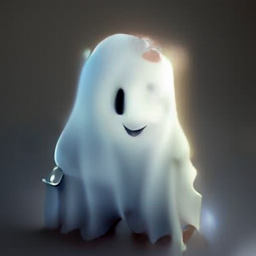

In [16]:
image

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `Amused` pipeline structure, the vision transformer model takes up significant portion of the overall pipeline execution time. Now we will show you how to optimize the UNet part using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce computation cost and speed up the pipeline. Quantizing the rest of the pipeline does not significantly improve inference performance but can lead to a substantial degradation of generations quality.

We also estimate the quality of generations produced by optimized pipeline with [Inception Score](https://en.wikipedia.org/wiki/Inception_score) which is often used to measure quality of text-to-image generation systems.

The steps are the following:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` on the model.
3. Save the quantized model using `openvino.save_model()` function.
4. Compare inference time and Inception score for original and quantized pipelines.  

Please select below whether you would like to run quantization to improve model inference speed.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [ ]:
from notebook_utils import quantization_widget

QUANTIZED_TRANSFORMER_OV_PATH = Path(str(TRANSFORMER_OV_PATH).replace(".xml", "_quantized.xml"))

skip_for_device = "GPU" in device.value
to_quantize = quantization_widget(not skip_for_device)
to_quantize

In [1]:
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [conceptual_captions](https://huggingface.co/datasets/google-research-datasets/conceptual_captions) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we customize `CompiledModel`.

In [ ]:
%%skip not $to_quantize.value

import datasets
from tqdm.auto import tqdm
from typing import Any, Dict, List
import pickle
import numpy as np


def disable_progress_bar(pipeline, disable=True):
    if not hasattr(pipeline, "_progress_bar_config"):
        pipeline._progress_bar_config = {'disable': disable}
    else:
        pipeline._progress_bar_config['disable'] = disable


class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model: ov.CompiledModel, data_cache: List[Any] = None, keep_prob: float = 0.5):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache is not None else []
        self.keep_prob = keep_prob

    def __call__(self, *args, **kwargs):
        if np.random.rand() <= self.keep_prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)


def collect_calibration_data(ov_transformer_model, calibration_dataset_size: int) -> List[Dict]:
    calibration_dataset_filepath = Path(f"calibration_data/{calibration_dataset_size}.pkl")
    if not calibration_dataset_filepath.exists():
        calibration_data = []
        pipe.transformer.transformer = CompiledModelDecorator(ov_transformer_model, calibration_data, keep_prob=1.0)
        disable_progress_bar(pipe)
    
        dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True).shuffle(seed=42)
    
        # Run inference for data collection
        pbar = tqdm(total=calibration_dataset_size)
        for batch in dataset:
            prompt = batch["caption"]
            if len(prompt) > pipe.tokenizer.model_max_length:
                continue
            pipe(prompt, generator=torch.Generator('cpu').manual_seed(0))
            pbar.update(len(calibration_data) - pbar.n)
            if pbar.n >= calibration_dataset_size:
                break
    
        pipe.transformer.transformer = ov_transformer_model
        disable_progress_bar(pipe, disable=False)
        
        calibration_dataset_filepath.parent.mkdir(exist_ok=True, parents=True)
        with open(calibration_dataset_filepath, 'wb') as f:
            pickle.dump(calibration_data, f)
            
    with open(calibration_dataset_filepath, 'rb') as f:
        calibration_data = pickle.load(f)
    return calibration_data

### Run model quantization
[back to top ⬆️](#Table-of-contents:)


Run calibration data collection and quantize the vision transformer model.

In [ ]:
%%skip not $to_quantize.value

from nncf.quantization.advanced_parameters import AdvancedSmoothQuantParameters
from nncf.quantization.range_estimator import RangeEstimatorParameters, StatisticsCollectorParameters, StatisticsType, \
    AggregatorType
import nncf

CALIBRATION_DATASET_SIZE = 12 * 25

if not QUANTIZED_TRANSFORMER_OV_PATH.exists():
    calibration_data = collect_calibration_data(ov_transformer, CALIBRATION_DATASET_SIZE)
    quantized_model = nncf.quantize(
        core.read_model(TRANSFORMER_OV_PATH),
        nncf.Dataset(calibration_data),
        model_type=nncf.ModelType.TRANSFORMER,
        subset_size=len(calibration_data),
        # We ignore convolutions to improve quality of generations without significant drop in inference speed
        ignored_scope=nncf.IgnoredScope(types=["Convolution"]),
        # Value of 0.85 was obtained using grid search based on Inception Score computed below
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            smooth_quant_alphas=AdvancedSmoothQuantParameters(matmul=0.85),
            # During activation statistics collection we ignore 1% of outliers which improves quantization quality
            activations_range_estimator_params=RangeEstimatorParameters(
                min=StatisticsCollectorParameters(statistics_type=StatisticsType.MIN,
                                                  aggregator_type=AggregatorType.MEAN_NO_OUTLIERS,
                                                  quantile_outlier_prob=0.01),
                max=StatisticsCollectorParameters(statistics_type=StatisticsType.MAX,
                                                  aggregator_type=AggregatorType.MEAN_NO_OUTLIERS,
                                                  quantile_outlier_prob=0.01)
            )
        )
    )
    ov.save_model(quantized_model, QUANTIZED_TRANSFORMER_OV_PATH)

### Demo generation with quantized pipeline

In [ ]:
%%skip not $to_quantize.value

original_ov_transformer_model = pipe.transformer.transformer
pipe.transformer.transformer = core.compile_model(QUANTIZED_TRANSFORMER_OV_PATH, device.value)

image = pipe(prompt, generator=torch.Generator('cpu').manual_seed(8)).images[0]
image.save('text2image_256_quantized.png')

pipe.transformer.transformer = original_ov_transformer_model

display(image)

### Compute Inception Scores and inference time
[back to top ⬆️](#Table-of-contents:)


Below we compute [Inception Score](https://en.wikipedia.org/wiki/Inception_score) of original and quantized pipelines on a small subset of images. Images are generated from prompts of `conceptual_captions` validation set. We also measure the time it took to generate the images for comparison reasons.

Please note that the validation dataset size is small and serves only as a rough estimate of generation quality.

In [ ]:
%%skip not $to_quantize.value

from torchmetrics.image.inception import InceptionScore
from torchvision import transforms as transforms
from itertools import islice
import time

VALIDATION_DATASET_SIZE = 100

def compute_inception_score(ov_transformer_model_path, validation_set_size, batch_size=100):
    original_ov_transformer_model = pipe.transformer.transformer
    pipe.transformer.transformer = core.compile_model(ov_transformer_model_path, device.value)
    
    disable_progress_bar(pipe)
    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", "unlabeled", split="validation", trust_remote_code=True).shuffle(seed=42)
    dataset = islice(dataset, validation_set_size)
    
    inception_score = InceptionScore(normalize=True, splits=1)
    
    images = []
    infer_times = []
    for batch in tqdm(dataset, total=validation_set_size, desc="Computing Inception Score"):
        prompt = batch["caption"]
        if len(prompt) > pipe.tokenizer.model_max_length:
            continue
        start_time = time.perf_counter()
        image = pipe(prompt, generator=torch.Generator('cpu').manual_seed(0)).images[0]
        infer_times.append(time.perf_counter() - start_time)
        image = transforms.ToTensor()(image)
        images.append(image)
    
    mean_perf_time = sum(infer_times) / len(infer_times)
        
    while len(images) > 0:
        images_batch = torch.stack(images[-batch_size:])
        images = images[:-batch_size]
        inception_score.update(images_batch)
    kl_mean, kl_std = inception_score.compute()
    
    pipe.transformer.transformer = original_ov_transformer_model
    disable_progress_bar(pipe, disable=False)
    
    return kl_mean, mean_perf_time


original_inception_score, original_time = compute_inception_score(TRANSFORMER_OV_PATH, VALIDATION_DATASET_SIZE)
print(f"Original pipeline Inception Score: {original_inception_score}")
quantized_inception_score, quantized_time = compute_inception_score(QUANTIZED_TRANSFORMER_OV_PATH, VALIDATION_DATASET_SIZE)
print(f"Quantized pipeline Inception Score: {quantized_inception_score}")
print(f"Quantization speed-up: {original_time / quantized_time:.2f}x")

## Interactive inference
[back to top ⬆️](#Table-of-contents:)

Below you can select which pipeline to run: original or quantized. 

In [ ]:
import ipywidgets as widgets

quantized_model_present = QUANTIZED_TRANSFORMER_OV_PATH.exists()

use_quantized_model = widgets.Checkbox(
    value=True if quantized_model_present else False,
    description="Use quantized pipeline",
    disabled=not quantized_model_present,
)

use_quantized_model

In [ ]:
from pathlib import Path

if not Path("gradio_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/amused-lightweight-text-to-image/gradio_helper.py"
    )
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

pipe.transformer.transformer = core.compile_model(
    QUANTIZED_TRANSFORMER_OV_PATH if use_quantized_model.value else TRANSFORMER_OV_PATH,
    device.value,
)

demo = make_demo(pipe)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/